In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '15G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("COVID") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'the-reddit-covid-dataset-comments.csv'
# Load the main data set into pyspark data frame 
df = spark.read.csv(filename_data, header=True, inferSchema=True)
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


In [3]:
# Создайте выборку
df = df.sample(withReplacement=False, fraction=0.01, seed=42)

In [4]:
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Columns overview


,Column Name,Data type
0,type,string
1,id,string
2,subreddit.id,string
3,subreddit.name,string
4,subreddit.nsfw,string
5,created_utc,string
6,permalink,string
7,body,string
8,sentiment,string
9,score,string


In [5]:
# Задайте новые имена столбцов
new_column_names = ['type', 'id', 'subreddit_id', 'subreddit_name', 'subreddit_nsfw', 'created_utc', 'permalink', 'body', 'sentiment', 'score'] 
# Создайте новый датасет с новыми именами столбцов, сохраняя типы данных
df = df.toDF(*new_column_names)

pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])
df.printSchema()

,Column Name,Data type
0,type,string
1,id,string
2,subreddit_id,string
3,subreddit_name,string
4,subreddit_nsfw,string
5,created_utc,string
6,permalink,string
7,body,string
8,sentiment,string
9,score,string


root
 |-- type: string (nullable = true)
 |-- id: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- subreddit_name: string (nullable = true)
 |-- subreddit_nsfw: string (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- body: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- score: string (nullable = true)



In [6]:
# Оставление только указанных столбцов
selected_columns = ['id', 'subreddit_name', 'subreddit_nsfw', 'sentiment', 'score']
df = df.select(selected_columns)

# Показать результат
df.show(4)

+-------+--------------+--------------+---------+-----+
|     id|subreddit_name|subreddit_nsfw|sentiment|score|
+-------+--------------+--------------+---------+-----+
|   NULL|          NULL|          NULL|     NULL| NULL|
|hi1v4vl|        canada|         false|  -0.7269|    1|
|hi1uyme|  conservative|         false|     NULL| NULL|
|hi1udht|       jontron|         false|     NULL| NULL|
+-------+--------------+--------------+---------+-----+
only showing top 4 rows



In [7]:
df = df.na.drop(subset=['id', 'subreddit_name', 'subreddit_nsfw', 'sentiment', 'score'])
df.show(2)

+-------+--------------+--------------+---------+-----+
|     id|subreddit_name|subreddit_nsfw|sentiment|score|
+-------+--------------+--------------+---------+-----+
|hi1v4vl|        canada|         false|  -0.7269|    1|
|hi1satq|           nrl|         false|  -0.7506|   46|
+-------+--------------+--------------+---------+-----+
only showing top 2 rows



In [8]:
# Преобразование столбца "sentiment" в числовой формат
df = df.withColumn("sentiment", col("sentiment").cast(FloatType()))

# Преобразование столбца "sentiment" в числовой формат
df = df.withColumn("score", col("score").cast(FloatType()))

In [9]:
# Определение квартилей для каждого столбца
quantiles = df.stat.approxQuantile(["sentiment", "score"], [0.25, 0.75], 0.05)

# Рассчет межквартильного размаха (IQR)
IQR_sentiment = quantiles[0][1] - quantiles[0][0]
IQR_score = quantiles[1][1] - quantiles[1][0]

# Определение границ выбросов
lower_bound_sentiment = quantiles[0][0] - 1.5 * IQR_sentiment
upper_bound_sentiment = quantiles[0][1] + 1.5 * IQR_sentiment

lower_bound_score = quantiles[1][0] - 1.5 * IQR_score
upper_bound_score = quantiles[1][1] + 1.5 * IQR_score

# Фильтрация данных для удаления выбросов
df_filtered = df.filter((col("sentiment").between(lower_bound_sentiment, upper_bound_sentiment)) &
                        (col("score").between(lower_bound_score, upper_bound_score)))

# Показать результат
df_filtered.show(3)

+-------+--------------+--------------+---------+-----+
|     id|subreddit_name|subreddit_nsfw|sentiment|score|
+-------+--------------+--------------+---------+-----+
|hi1v4vl|        canada|         false|  -0.7269|  1.0|
|hi1q4qb|toiletpaperusa|         false|   0.4815|  3.0|
|hi1pi1o|    ukpolitics|         false|  -0.9432|  1.0|
+-------+--------------+--------------+---------+-----+
only showing top 3 rows



In [10]:
# Вычисление статистических показателей
summary = df_filtered.describe()

# Показать результат
summary.show(3)

+-------+------+-----------------+------------------+--------------------+------------------+
|summary|    id|   subreddit_name|    subreddit_nsfw|           sentiment|             score|
+-------+------+-----------------+------------------+--------------------+------------------+
|  count| 68557|            68557|             68557|               68557|             68557|
|   mean|2020.0|373.0833333333333|              11.5|0.033164276435660625|  2.56109514710387|
| stddev|  NULL|504.2159575856936|2.1213203435596424|  0.5534243957659374|2.7261618785857538|
+-------+------+-----------------+------------------+--------------------+------------------+
only showing top 3 rows



In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean
# Вычисление среднего значения
mean_score = df_filtered.select(mean("score").alias("mean_score")).collect()[0]["mean_score"]

# Вычисление квартилей (25%, 50%, 75%) для столбца "score"
quantiles_score = df_filtered.stat.approxQuantile("score", [0.25, 0.5, 0.75], 0.05)

# Печать результатов
print(f"Mean Score: {mean_score}")
print(f"25th Percentile: {quantiles_score[0]}")
print(f"50th Percentile (Median): {quantiles_score[1]}")
print(f"75th Percentile: {quantiles_score[2]}")

Mean Score: 2.56109514710387
25th Percentile: 1.0
50th Percentile (Median): 2.0
75th Percentile: 3.0


In [12]:
# Вычисление среднего значения
mean_score = df_filtered.select(mean("sentiment").alias("mean_sentiment")).collect()[0]["mean_sentiment"]

# Вычисление квартилей (25%, 50%, 75%) для столбца "sentiment"
quantiles_score = df_filtered.stat.approxQuantile("sentiment", [0.25, 0.5, 0.75], 0.05)

# Печать результатов
print(f"Mean Score: {mean_score}")
print(f"25th Percentile: {quantiles_score[0]}")
print(f"50th Percentile (Median): {quantiles_score[1]}")
print(f"75th Percentile: {quantiles_score[2]}")

Mean Score: 0.033164276435660625
25th Percentile: -0.4449000060558319
50th Percentile (Median): 0.0
75th Percentile: 0.429500013589859


In [13]:
from pyspark.sql.functions import col, count, lit, when, sum
# Вычисление частоты появления каждого subreddit
subreddit_counts = df_filtered.groupBy("subreddit_name").agg(count("*").alias("count"))

# Вычисление общего количества записей
total_count = df_filtered.count()

# Вычисление процентного соотношения
subreddit_percentages = subreddit_counts.withColumn(
    "percentage",
    (col("count") / total_count * 100).cast("double")
)

# Определение порога для объединения в группу Other (например, значения, которые встречаются только один раз)
threshold = 1

# Фильтрация значений для группировки в Other
subreddit_percentages_filtered = (
    subreddit_percentages
    .withColumn("subreddit_grouped", 
                when(col("count") > threshold, col("subreddit_name"))
                .otherwise(lit("Other")))
    .groupBy("subreddit_grouped")
    .agg(sum("count").alias("total_count"), sum("percentage").alias("total_percentage"))
    .orderBy("total_percentage", ascending=False)
)

# Преобразовываем результаты в Pandas DataFrame
subreddit_percentages_filtered_pd = subreddit_percentages_filtered.toPandas()

# Печать результатов с параметром truncate=False
print(subreddit_percentages_filtered_pd)

        subreddit_grouped  total_count  total_percentage
0                   Other         4528          6.604723
1               askreddit         2678          3.906239
2                politics         2310          3.369459
3             coronavirus         1768          2.578876
4              conspiracy         1475          2.151494
...                   ...          ...               ...
4132                piano            2          0.002917
4133               runnyc            2          0.002917
4134            reloading            2          0.002917
4135  crackheadcraigslist            2          0.002917
4136      highereducation            2          0.002917

[4137 rows x 3 columns]


In [14]:
nsfw_column = "subreddit_nsfw"

# Преобразуем строковые значения в булев тип
df_filtered = df_filtered.withColumn(nsfw_column, col(nsfw_column).cast("boolean"))

# Группируем по столбцу NSFW и считаем количество элементов в каждой группе
grouped_df = df_filtered.groupBy(nsfw_column).count()

# Получаем количество элементов в каждой группе
nsfw_count = grouped_df.filter(col(nsfw_column) == True).select("count").first()[0]
sfw_count = grouped_df.filter(col(nsfw_column) == False).select("count").first()[0]

# Выводим процентное соотношение
total_count = nsfw_count + sfw_count
nsfw_percentage = (nsfw_count / total_count) * 100
sfw_percentage = (sfw_count / total_count) * 100

# Выводим результат
print(f"NSFW: {nsfw_count} элементов, {nsfw_percentage:.2f}%")
print(f"SFW: {sfw_count} элементов, {sfw_percentage:.2f}%")

# Отображаем график
plt.show()

NSFW: 501 элементов, 0.74%
SFW: 67657 элементов, 99.26%


<BarContainer object of 9 artists>

Text(0.5, 0, 'Sentiment Group')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Sentiment Analysis Distribution')

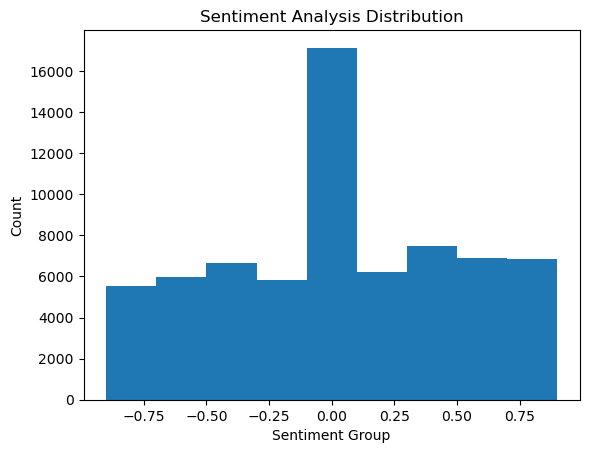

In [15]:
# Группировка по диапазонам и подсчет количества элементов в каждой группе
grouped_df = df_filtered.groupBy(((col("sentiment") / 0.2).cast("int") * 0.2).alias("sentiment_group")).count()

# Сортировка результатов по группам
grouped_df = grouped_df.sort("sentiment_group")

# Конвертация в Pandas DataFrame для удобства работы с matplotlib
pandas_df = grouped_df.toPandas()

# Вывод результатов на график
plt.bar(pandas_df["sentiment_group"], pandas_df["count"], width=0.2)
plt.xlabel("Sentiment Group")
plt.ylabel("Count")
plt.title("Sentiment Analysis Distribution")
plt.show()

In [16]:
# Группировка по subreddit_name и подсчет суммы score для каждого subreddit_name
subreddit_scores = df_filtered.groupBy("subreddit_name").sum("score")

# Сортировка результатов по убыванию score и выбор топ-10
top_subreddits = subreddit_scores.sort(col("sum(score)").desc()).limit(10)

# Показ результатов
top_subreddits.show()

+---------------+----------+
| subreddit_name|sum(score)|
+---------------+----------+
|       politics|    5942.0|
|    coronavirus|    4812.0|
|      askreddit|    4750.0|
|     conspiracy|    3058.0|
|           news|    2959.0|
|      worldnews|    2036.0|
|    nonewnormal|    1947.0|
| wallstreetbets|    1888.0|
|hermancainaward|    1744.0|
| publicfreakout|    1302.0|
+---------------+----------+



In [17]:
# Вычисление коэффициента корреляции Пирсона
correlation = df_filtered.corr("sentiment", "score")

# Вывод результата
print(f"Correlation between sentiment and score: {correlation}")

Correlation between sentiment and score: 0.002129581974703576
